In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck
from project.utils import memcheck, compute_statistics

In [2]:
import logging
logger = logging.getLogger('nigel_AE')
fh = logging.FileHandler('logs/nigel_AE.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [4]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(385, 7)

In [5]:
data.drop_duplicates(subset='mri', inplace=True)
data.shape

(11, 7)

In [6]:
# data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
# data

In [7]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [8]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique CMBs in data_train {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader, train_set, val_set

In [9]:
train_loader, val_loader, train_set, val_set = make_loaders(
    data=data,
    cohort=1,
    batch_size=10,
)

Creating loaders for Cohort 1
TRAIN & TEST: ((8, 7), (2, 7))
Total Unique CMBs in data_train 8
GLOBAL MIN & MAX (0.0, 1031.220458984375)



### Config for fitter

In [10]:
from project.model import SliceEmbedding, Autoencoder, Decoder

en = SliceEmbedding(
    image_size=300,
    output_dim=512,
)

de = Decoder(
    image_size=300,
    input_dim=512
)

config = {
    'model': Autoencoder(en, de).to(device),
    # 'optimizer' : torch.optim.Adam,
    # 'optimizer': torch.optim.Adamax,
    # 'optimizer': torch.optim.AdamW,
    # 'optimizer': torch.optim.Adagrad,
    'optimizer': torch.optim.RAdam,        
    'device': device,
    'epochs': 170,
    # 'loss': nn.L1Loss(),
    # 'loss': nn.SmoothL1Loss(),
    'loss' : nn.HuberLoss(),  
    # 'loss': nn.SoftMarginLoss(),
    # 'loss': nn.MSELoss(),

    'lr': 0.00075
}

324


### Sample trial

### Fitter

In [11]:
# Main Fitter class
# skeletal structure of Fitter class
# override and add methods as needed

import torch

class Fitter:
    def __init__(self, config, logger=None):
        self.model = config['model']
        self.optimizer = config['optimizer'](self.model.parameters(), lr=config['lr'])
        self.device = config['device']
        self.epochs = config['epochs']
        self.loss = config['loss']
        self.logger = logger

    def log(self, s):
        if self.logger:
            self.logger.info(s)
        else:
            print(s)

    def fit(self, train_loader, val_loader, train_set, val_set):
        # keep track of history
        train_history = []
        val_history = []

        # loop with self.epochs
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')

            # train with self.train_one_epoch
            train_loss = self.train_one_epoch(train_loader, train_set)

            # validate
            val_loss = self.validation(val_loader, val_set)

            # add losses to histories
            train_history.append(train_loss)
            val_history.append(val_loss)

            # if epoch % 100 == 0:
            #     print(f"Epoch: {epoch}\tLoss: {train_loss}\tTest Loss: {val_loss}")

        return train_history, val_history

    def train_one_epoch(self, train_loader, train_set):
        self.model.train()
        # train model
        pass

    def validation(self, val_loader, val_set):
        self.model.eval()
        with torch.inference_mode():
            # conduct evaluation
            pass
        pass


In [12]:
class AEFitter(Fitter):
    def train_one_epoch(self, train_loader, train_set):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                if slices is None:
                    logger.error(f'CASE NOT WORKING: {case}')
                    continue
                x = slices.squeeze(1).float().to(self.device)
                y = self.model(x)
                print(y.shape)
                logger.info(f'MEMORY after X, Y, T to device\t{memcheck()}')
                losses = self.loss(y, x)
                self.optimizer.zero_grad()
                losses.backward()
                self.optimizer.step()
                loss_history.append(losses.detach().cpu().numpy())
            
            counter += len(batch)
            if counter % 100 == 0:
                logger.info(f'Progress:\t{counter}/{len(train_set)}')
                logger.info(f'Current error:\t{losses}')
            
            # del losses, Y, T
            # torch.cuda.empty_cache()
            # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
            
        return loss_history
    
    def validation(self, val_loader, val_set):
        self.model.eval()
        with torch.inference_mode():
            loss_history = []
            counter = 0
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    if slices is None:
                        logger.error(f'CASE NOT WORKING: {case}')
                        continue
                    x = slices.squeeze(1).float().to(self.device)
                    y = self.model(x)
                    logger.info(f'MEMORY after X, Y, T to device\t{memcheck()}')
                    losses = self.loss(y, x)
                    loss_history.append(losses.detach().cpu().numpy())
                
                counter += len(batch)
                if counter % 100 == 0:
                    logger.info(f'Progress:\t{counter}/{len(val_set)}')
                    logger.info(f'Current error:\t{losses}')
                
                # del losses, Y, T
                # torch.cuda.empty_cache()
                # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
                
            return loss_history

In [13]:
fitter = AEFitter(config)

### Training

In [14]:
hist = fitter.fit(train_loader, val_loader, train_set, val_set)

EPOCH 0 ==============================
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 352, 352])
EPOCH 1 ==============================
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])
torch.Size([35, 1, 352

In [15]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

In [16]:
train_hist, val_hist = hist

tensor([0.0709, 0.0700, 0.0687, 0.0669, 0.0649, 0.0626, 0.0602, 0.0576, 0.0548,
        0.0518, 0.0481, 0.0425, 0.0336, 0.0226, 0.0137, 0.0085, 0.0059, 0.0046,
        0.0041, 0.0039, 0.0038, 0.0037, 0.0037, 0.0036, 0.0036, 0.0036, 0.0035,
        0.0035, 0.0035, 0.0034, 0.0034, 0.0033, 0.0031, 0.0028, 0.0024, 0.0021,
        0.0021, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0019, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017,
        0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0015,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 

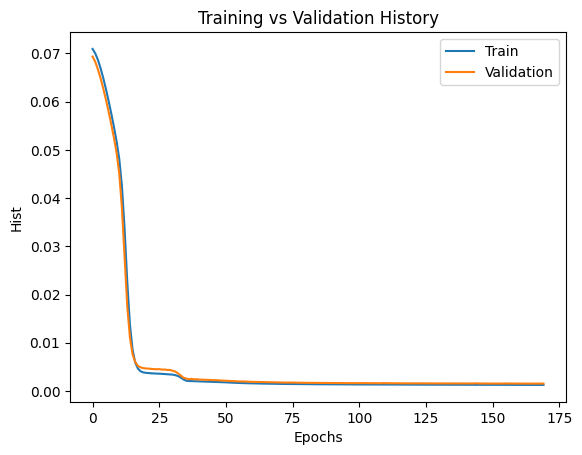

In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

print(torch.tensor(np.array(train_hist)).mean(1))
print(torch.tensor(np.array(val_hist)).mean(1))
sns.lineplot(torch.tensor(np.array(train_hist)).mean(1), label="Train")
sns.lineplot(torch.tensor(np.array(val_hist)).mean(1), label="Validation")

plt.title("Training vs Validation History")
plt.xlabel("Epochs")
plt.ylabel("Hist")

plt.legend()

plt.show()

In [18]:
moded = config['model']

# Summary

Working training now for autoencoder

### Save Encoder Weights

In [19]:
import datetime

s = f'weights/Encoder_weights_Final_{datetime.datetime.now().strftime("%d%m%y%H%M%S")}.pt'
s

'weights/Encoder_weights_Final_301024174303.pt'

In [20]:
model = config['model']

In [21]:
enc = model.encoder
torch.save(enc.state_dict(), s)

In [22]:
def printMRI(data, slice):
    return sns.heatmap(data[slice].squeeze(0).detach().cpu().numpy())

In [23]:
model = fitter.model

In [24]:
model

Autoencoder(
  (encoder): SliceEmbedding(
    (convs): Sequential(
      (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): ReLU()
      (2): Conv2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(32, 24, kernel_size=(2, 2), stride=(2, 2))
      (5): ReLU()
      (6): Conv2d(24, 1, kernel_size=(2, 2), stride=(2, 2))
      (7): ReLU()
      (8): Dropout(p=0.1, inplace=False)
      (9): Flatten(start_dim=2, end_dim=-1)
    )
    (mlp): Sequential(
      (0): Linear(in_features=324, out_features=512, bias=True)
    )
  )
  (decoder): Decoder(
    (imager): Sequential(
      (0): Linear(in_features=512, out_features=484, bias=True)
      (1): Unflatten(dim=2, unflattened_size=(22, 22))
    )
    (upconvs): Sequential(
      (0): ConvTranspose2d(1, 24, kernel_size=(2, 2), stride=(2, 2))
      (1): ELU(alpha=1.0)
      (2): ConvTranspose2d(24, 24, kernel_size=(4, 4), stride=(4, 4))
      (3): ELU(alpha=1.0)
      (4): ConvTranspose2d(24, 1, kernel

torch.Size([35, 1, 352, 352])
torch.Size([35, 1, 300, 300])


<Axes: >

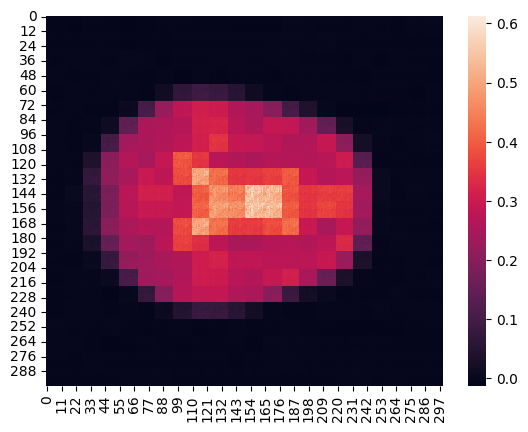

In [25]:
batch = next(enumerate(train_loader))
sample = batch[1][0]
slices, masks, target, case = sample
x = slices.squeeze(1).float().to(device)
y = model(x)
print(y.shape)
printMRI(y, 20)


torch.Size([35, 1, 300, 300])


<Axes: >

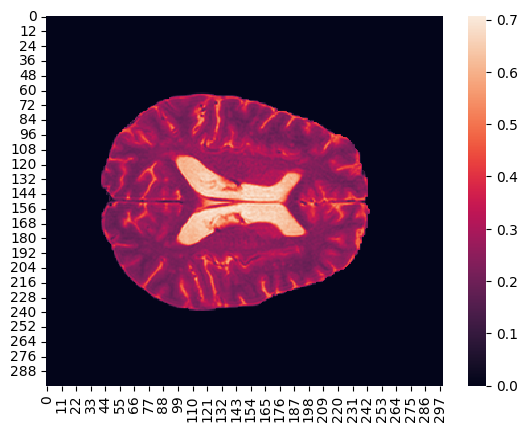

In [26]:
print(x.shape)
printMRI(x, 20)

# Trial